In [12]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from matplotlib import pyplot as plt
fnames = ['PrimaryVoters.xlsx','Voter Data.xlsx']

import geopandas as gpd
from shapely.geometry import Point, Polygon
from matplotlib.colors import LogNorm
from matplotlib.cm import ScalarMappable
import matplotlib.animation as animation
"""
TO DO
Separate the address columns
Street Address, City, ZIP
"""

'\nTO DO\nSeparate the address columns\nStreet Address, City, ZIP\n'

Read in Geopandas Data

In [13]:
geo_data = gpd.read_file('Utah_Vista_Ballot_Areas.geojson')
geo_data_copy = geo_data.copy()
geo_data = geo_data[geo_data['AliasName'] == 'Provo']
geo_data = geo_data.loc[:,['PrecinctID','SHAPE_Area','geometry']]

Examine Geo Data

In [14]:
print(list(geo_data_copy.columns))
geo_data.rename(columns={'PrecinctID':'PRECINCT','SHAPE_Area':'AREA'},inplace=True)
# geo_data

['OBJECTID', 'CountyID', 'VistaID', 'PrecinctID', 'SubPrecinctID', 'VersionNbr', 'EffectiveDate', 'AliasName', 'Comments', 'RcvdDate', 'GlobalID', 'SHAPE_Length', 'SHAPE_Area', 'geometry']


Primary and General Voter Data read in

In [15]:
primary = pd.read_excel(fnames[0])
mask = primary['CITY'] == 'Provo'
primary_copy = primary.copy()
primary_copy = primary.copy()
primary_addresses = primary.copy()

#Read in general voting data, rename columns to match style of primary voting dataframe
general = pd.read_excel(fnames[1])
general.rename(columns={'Voter ID':'VOTER_ID','Precinct':'PRECINCT'},inplace=True)
general_addresses = general.copy()
general_copy = general.copy()

Primary and General Voter Data Formatting

In [16]:
# Read in only primary data for the city of Provo, keep only the Provo primary votes
primary = primary_copy.copy()
mask = primary['CITY'] == 'Provo'
primary = primary[mask]
primary = primary[['VOTER_ID','VOTED','PRECINCT']]

#Change VOTED column to 1s everywhere
primary['VOTED'] = 1

#Read in general voting data, rename columns to match style of primary voting dataframe
general = general_copy.copy()

#Get just voter ID, precinct, and election voting data
general2 = general[['VOTER_ID','PRECINCT']]
how_voted = general.filter(like='How Voted')

#Change "How Voted" to just 1's and 0's to indicate not voting or voting in given election
def fill_with_numbers(x):
    if pd.isna(x):
        return 0
    else:
        return 1
how_voted = how_voted.applymap(fill_with_numbers)
general2 = pd.concat([general2,how_voted],axis=1)

#Merge the dataframes, rename the primary voted column like all other voted columns
merged = pd.merge(general2,primary,on = 'VOTER_ID',how = 'outer')
merged.rename(columns={'VOTED':'How Voted.44'},inplace=True)
merged.fillna(0,inplace=True)

#Combine the precinct columns
merged['PRECINCT'] = np.where(merged['PRECINCT_x'] == 0, merged['PRECINCT_y'], merged['PRECINCT_x'])
merged.drop(columns=['PRECINCT_y','PRECINCT_x'],inplace=True)



Construct Separate Address DataFrames

In [17]:
primary_addresses = primary_copy.copy()
mask = primary_addresses['CITY'] == 'Provo'
primary_addresses = primary_addresses[mask]
general_addresses = general_copy.copy()

#Fill NaN, rename columns to match
primary_addresses.fillna('',inplace=True)
general_addresses.fillna('',inplace=True)
general_addresses.rename(columns={'Voter ID':'VOTER_ID','Precinct':'PRECINCT'},inplace=True)

#Rename street address, city, zip columns of primary_addresses
primary_addresses.rename(columns={'RESIDENCE_ADDRESS':'Street Address','CITY':'City','ZIP':'Zip'},inplace=True)
primary_addresses['Zip'] = primary_addresses['Zip'].astype(str)

#Get street address, city, zip columns of general_addresses
general_addresses["Street Address"] = general_addresses['House Number'].astype(str) + ' ' + general_addresses['Direction Prefix'].astype(str) + \
                                        ' ' + general_addresses['Street'].astype(str) + ' ' + general_addresses['Direction Suffix'].astype(str) +\
                                        ' ' + general_addresses['Street Type'].astype(str) + ' ' + general_addresses['Unit Type'].astype(str) + ' ' + general_addresses['Unit Number'].astype(str)
general_addresses['Zip'] = general_addresses['Zip'].astype(str)
general_addresses.rename(columns={'Mailing city, state  zip':'Mailing City, State, Zip'},inplace=True)

primary_addresses['Full Name'] = primary_addresses['FIRST'] + ' ' + primary_addresses['NAME']
general_addresses['Full Name'] = general_addresses['First Name'] + ' ' + general_addresses['Last Name']
# general_addresses['Mailing Address'] = general_addresses['Mailing Address'] + ' ' + general_addresses['Mailing city, state  zip']

#Make full address,mailing address, and full name columns for each dataframe
# primary_addresses["Full Address"] = primary_addresses['RESIDENCE_ADDRESS'] + ' ' + primary_addresses['CITY'] + ' ' + primary_addresses['ZIP'].astype(str)
# general_addresses["Full Address"] = general_addresses['House Number'].astype(str) + ' ' + general_addresses['Direction Prefix'].astype(str) + ' ' + general_addresses['Street'].astype(str) + ' ' + general_addresses['Direction Suffix'].astype(str) \
#                                     + ' ' + general_addresses['Street Type'].astype(str) + ' ' + general_addresses['Unit Type'].astype(str) + ' ' + general_addresses['Unit Number'].astype(str) + ' ' + general_addresses['City'].astype(str) + ' ' + \
#                                     general_addresses['Zip'].astype(str)
# primary_addresses['Full Name'] = primary_addresses['FIRST'] + ' ' + primary_addresses['NAME']
# general_addresses['Full Name'] = general_addresses['First Name'] + ' ' + general_addresses['Last Name']
# general_addresses['Mailing Address'] = general_addresses['Mailing Address'] + ' ' + general_addresses['Mailing city, state  zip']

#Only keep the voterID, precinct, address info, and name
primary_addresses = primary_addresses.loc[:,['VOTER_ID','PRECINCT','Full Name','Street Address','City','Zip']]
general_addresses = general_addresses.loc[:,['VOTER_ID','PRECINCT','Full Name','Street Address','City','Zip','Mailing Address','Mailing City, State, Zip']]

#Join them together
merged_addresses = pd.merge(general_addresses,primary_addresses,on = 'VOTER_ID',how = 'outer')
merged_addresses.fillna(0,inplace=True)
merged_addresses['Mailing Address'].mask(merged_addresses['Mailing Address']==0,'',inplace= True)
merged_addresses['Mailing City, State, Zip'].mask(merged_addresses['Mailing City, State, Zip']==0,'',inplace= True)

#Combine the precinct columns
merged_addresses['PRECINCT'] = np.where(merged_addresses['PRECINCT_x'] == 0, merged_addresses['PRECINCT_y'], merged_addresses['PRECINCT_x'])
merged_addresses.drop(columns=['PRECINCT_y','PRECINCT_x'],inplace=True)

#Combine the Name Columns
merged_addresses['Full Name'] = np.where(merged_addresses['Full Name_x'] == 0, merged_addresses['Full Name_y'], merged_addresses['Full Name_x'])
merged_addresses.drop(columns=['Full Name_y','Full Name_x'],inplace=True)

#Combine the Address,City,ZIP Columns
merged_addresses['Street Address'] = np.where(merged_addresses['Street Address_x'] == 0, merged_addresses['Street Address_y'], merged_addresses['Street Address_x'])
merged_addresses.drop(columns=['Street Address_y','Street Address_x'],inplace=True)
merged_addresses['Zip'] = np.where(merged_addresses['Zip_x'] == 0, merged_addresses['Zip_y'], merged_addresses['Zip_x'])
merged_addresses.drop(columns=['Zip_y','Zip_x'],inplace=True)
merged_addresses['City'] = 'Provo'
merged_addresses.drop(columns=['City_y','City_x'],inplace=True)
merged_addresses['State'] = 'UT'
merged_addresses = merged_addresses.loc[:,['VOTER_ID','PRECINCT','Full Name','Street Address','City','State','Zip','Mailing Address','Mailing City, State, Zip']]
merged_addresses

,VOTER_ID,PRECINCT,Full Name,Street Address,City,State,Zip,Mailing Address,"Mailing City, State, Zip"
0,6208866,PR302,Sharron Collier,77 W 4800 N Unit A241,Provo,UT,84604-5788,,
1,6468144,PR308,Nancy Macfarlane,4146 N University Ave Apt 1203,Provo,UT,84604-4960,,
2,6282452,PR310,Dixie Clifford,3352 N 100 E Apt 303,Provo,UT,84604-6662,,
3,6370297,PR310,Horace Young,3352 N 100 E Apt 231,Provo,UT,84604-6606,,
4,6205806,PR313,Kim Jackson,3024 N Comanche Ln,Provo,UT,84604-4344,,
...,...,...,...,...,...,...,...,...,...
37669,2131347,PR360,Amber Hawkins,822 S Aspen Way,Provo,UT,84606,,
37670,2696863,PR362,Rita Miyarez,1717 E 1400 S,Provo,UT,84606,,
37671,2497293,PR363,Anna Jesperson,1237 S 1410 E,Provo,UT,84606,,
37672,1460372,PR363,Elizabeth Thomas,2345 Tennessee Ave,Provo,UT,84606,,


Make pivot tables with no weighting, just ranking the total number of votes counted in each precinct

In [18]:
merged["How Voted Sum"] = merged.loc[:,'How Voted':'How Voted.44'].sum(axis=1)
table2 = merged.pivot_table(values = 'How Voted Sum',index = ['PRECINCT'], aggfunc='sum')
table2 = table2.reindex(table2.sort_values(by='How Voted Sum', ascending=False).index)

Do Least Squares to weight the votes

In [19]:
#Use all the voting data + primary as the independent vars, the most recent election (how voted 43) as the dependent var to find weights
predictive_voting_data = merged.loc[:,'How Voted':'How Voted.44'].drop(columns=['How Voted.43']).to_numpy()
predictive_vote = merged.loc[:,'How Voted.43'].to_numpy() * 43
weights = np.linalg.lstsq(predictive_voting_data,predictive_vote,rcond=None)[0]

#Apply weights to all voting data, just shifted 1 election up
merged2 = merged.copy()
merged2.drop(columns=['How Voted Sum','How Voted'],inplace=True)
columns = merged2.columns
columns = list(columns)
columns.remove('VOTER_ID')
columns.remove('PRECINCT')
columns.remove('How Voted.44')

for (i,col) in enumerate(columns):
    merged2[col] = merged2[col] * weights[i]
merged2['How Voted.44'] = merged2['How Voted.44'] * weights[-1]

#Sum now weighted values
merged2["How Voted Sum"] = merged2.loc[:,'How Voted.1':'How Voted.44'].sum(axis=1)

#make the pivot table
table_LS = merged2.pivot_table(values = 'How Voted Sum',index = ['PRECINCT'], aggfunc='sum')
table_LS = table_LS.reindex(table_LS.sort_values(by='How Voted Sum', ascending=False).index)

Do Least Squares to weight the votes, but this time examining a municipal election

In [20]:
#Election 41 was a municipal election in an off year, try using that
predictive_voting_data2 = merged.loc[:,'How Voted':'How Voted.40'].to_numpy()
predictive_vote2 = merged.loc[:,'How Voted.41'].to_numpy() * 40
weights2 = np.linalg.lstsq(predictive_voting_data2,predictive_vote2,rcond=None)[0]

#Apply weights to all voting data, just shifted 1 election up
merged3 = merged.copy()
merged3 = merged3.drop(columns=['How Voted.41','How Voted.42','How Voted.43','How Voted.44','How Voted Sum'])
columns = merged3.columns
columns = list(columns)
columns.remove('VOTER_ID')
columns.remove('PRECINCT')

for (i,col) in enumerate(columns):
    merged3[col] = merged3[col] * weights2[i]

#Sum now weighted values
merged3["How Voted Sum"] = merged3.loc[:,'How Voted.1':'How Voted.40'].sum(axis=1)

#make the pivot table
table_LS2 = merged3.pivot_table(values = 'How Voted Sum',index = ['PRECINCT'], aggfunc='sum')
table_LS2 = table_LS2.reindex(table_LS2.sort_values(by='How Voted Sum', ascending=False).index)
table_LS2.to_csv('table3.csv')


Plot weights to determine what our overall weights should look like

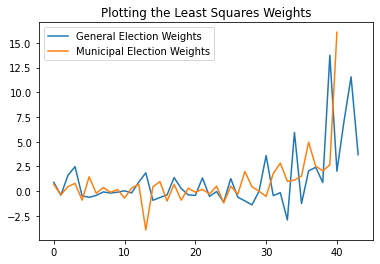

In [21]:
plt.plot(weights,label = 'General Election Weights')
plt.plot(weights2,label = 'Municipal Election Weights')
plt.legend()
plt.title('Plotting the Least Squares Weights')
plt.show()

Do linear weighting (from 1 up til 4) for everything except the primary, weight the primary as x15
Generate CSV of precincts ranked, as well as voters ranked

In [22]:
#Define linear weighting function
def linear_weight(pos):
    #Linearly weights the first 44 (0 indexed) (non primary) elections from 1 to 4
    b = 1
    m = (4-1)/(43-0)
    return m*pos + b

#Apply weights to all voting data
final_data = merged.copy()
final_data.drop(columns=['How Voted Sum'],inplace=True)
columns = final_data.columns
columns = list(columns)
columns.remove('VOTER_ID')
columns.remove('PRECINCT')
columns.remove('How Voted.44')
for (i,col) in enumerate(columns):
    weight = linear_weight(i)
    final_data[col] = final_data[col] * weight
final_data['How Voted.44'] = final_data['How Voted.44'] * 15

#Sum now weighted values
final_data["Weighted Votes Sum"] = final_data.loc[:,'How Voted':'How Voted.44'].sum(axis=1)

#make the pivot table ranking precincts
table_final = final_data.pivot_table(values = 'Weighted Votes Sum',index = ['PRECINCT'], aggfunc='sum')
table_final.sort_values(by='Weighted Votes Sum',ascending=False,inplace=True)
# table_final.to_csv('Precincts_ranked.csv')

#Join the final ranked list of voters with the name and address info, make csv of ranked voters
final_data = final_data[final_data['VOTER_ID']!= 0]
merged_addresses = merged_addresses[merged_addresses['VOTER_ID']!= 0]
final_ranking_with_addresses = pd.merge(final_data.loc[:,['VOTER_ID','Weighted Votes Sum']],merged_addresses,on = 'VOTER_ID')#,how = 'outer')
final_ranking_with_addresses.set_index('VOTER_ID',inplace=True)
final_ranking_with_addresses.sort_values(by='Weighted Votes Sum',ascending=False,inplace=True)
final_ranking_with_addresses.to_csv('Voters_ranked.csv')

Normalize Precinct rankings by land area of each precinct

In [23]:
precincts_with_geodata = pd.merge(geo_data,table_final,on = 'PRECINCT')
precincts_with_geodata['Weighted Votes Sum'] = precincts_with_geodata['Weighted Votes Sum'] /precincts_with_geodata['AREA']
precincts_with_geodata = pd.DataFrame(precincts_with_geodata)
precincts_with_geodata.drop(columns=['geometry','AREA'],inplace =True)
precincts_with_geodata.sort_values(by='Weighted Votes Sum',ascending=False,inplace=True)
precincts_with_geodata.set_index('PRECINCT',inplace=True)
precincts_with_geodata.rename(columns={'Weighted Votes Sum':'Voting Density'},inplace=True)
precincts_with_geodata.to_csv('Precincts_ranked_density.csv')

37674 rows should be there